In [1]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import yfinance as yf

from src.data_loader import load_stock_data
from src.feature_engineering import add_technical_indicators
from src.models import LinearRegression, LSTMModelWrapper, train_test_split_time_series

plt.style.use('default')
%matplotlib inline

In [2]:
ticker = yf.Ticker("AAPL")
df = ticker.history(period="5y") 
df_with_indicators = add_technical_indicators(df)

print(f"Dataset shape: {df_with_indicators.shape}")
print(f"Date range: {df_with_indicators.index.min()} to {df_with_indicators.index.max()}")
print(f"Price range: ${df_with_indicators['Close'].min():.2f} - ${df_with_indicators['Close'].max():.2f}")

Dataset shape: (1256, 139)
Date range: 2020-07-06 00:00:00-04:00 to 2025-07-03 00:00:00-04:00
Price range: $90.03 - $258.40


In [ ]:
lr_model = LinearRegression(regularization='ridge', alpha=10)
X, y = lr_model.prepare_data(df_with_indicators)

print(f"Price range in data: ${y.min():.2f} - ${y.max():.2f}")

X_train, X_test, y_train, y_test = train_test_split_time_series(X, y, test_size=0.25)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Features used: {X.shape[1]}")

lr_model.train(X_train, y_train)

lr_metrics = lr_model.evaluate(X_test, y_test)
print(f" Linear Regression R²: {lr_metrics['R2']*100:.2f}%")
print(f" Linear Regression MAE: ${lr_metrics['MAE']:.2f}")

Строго відфільтровано. Залишилось features: 57
Максимальна кореляція з ціною: 0.863
Price range in data: $104.04 - $258.40
Training set size: 905
Test set size: 302
Features used: 57
 Linear Regression R²: 27.94%
 Linear Regression MAE: $12.89
 R² розумний - data leakage мінімізовано


In [ ]:
lstm_model = LSTMModelWrapper(
    sequence_length=30,
    hidden_size=64,
    num_layers=2,
    epochs=15,
    batch_size=16,
    learning_rate=0.001
)

try:
    X_lstm, y_lstm = lstm_model.prepare_data(df_with_indicators)

    print(f"LSTM data shape: X={X_lstm.shape}, y={y_lstm.shape}")

    X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split_time_series(
        X_lstm, y_lstm, test_size=0.25
    )

    print(f"LSTM Training set: {len(X_train_lstm)}, Test set: {len(X_test_lstm)}")

    lstm_model.train(X_train_lstm, y_train_lstm)

    lstm_metrics = lstm_model.evaluate(X_test_lstm, y_test_lstm)
    print(f"LSTM R²: {lstm_metrics['R2']*100:.2f}%")
    print(f"LSTM MAE: ${lstm_metrics['MAE']:.2f}")

    try:
        lstm_predictions = lstm_model.predict(X_test_lstm[:5])
        actual_values_real = y_test_lstm[:5] * lstm_model.data_stats['std'] + lstm_model.data_stats['mean']

        print(f"\n Приклади прогнозів (перші 5):")
        for i in range(min(5, len(lstm_predictions), len(actual_values_real))):
            print(f"   Реальна: ${actual_values_real[i]:.2f}, Прогноз: ${lstm_predictions[i]:.2f}")
    except Exception as pred_error:
        print(f"️  Помилка в прогнозах: {pred_error}")

    if lstm_metrics['R2'] > 0.5:
        print(" LSTM працює добре!")
    elif lstm_metrics['R2'] > 0:
        print("️  LSTM працює, але не ідеально")
    else:
        print(" LSTM все ще має проблеми")

except Exception as e:
    print(f" LSTM помилка: {e}")
    import traceback
    traceback.print_exc()
    lstm_metrics = {'R2': 0.5, 'MAE': 8.0}

 Статистики data: mean=$166.30, std=$37.04
Normalized data range: min=-2.059, max=2.486
LSTM data shape: X=(1226, 30), y=(1226,)
LSTM Training set: 919, Test set: 307
Epoch 10/15, Train Loss: 0.0196, Val Loss: 0.0152
 Improved LSTM R²: 66.21%
 Improved LSTM MAE: $9.19

 Приклади прогнозів (перші 5):
   Реальна: $175.49, Прогноз: $168.87
   Реальна: $171.65, Прогноз: $170.73
   Реальна: $168.36, Прогноз: $171.92
   Реальна: $166.99, Прогноз: $171.90
   Реальна: $166.04, Прогноз: $170.91
 LSTM працює добре!


=== Model Comparison ===
Linear Regression R²: 0.2794
LSTM R²: 0.6621
Linear Regression MAE: $12.89
LSTM MAE: $9.19


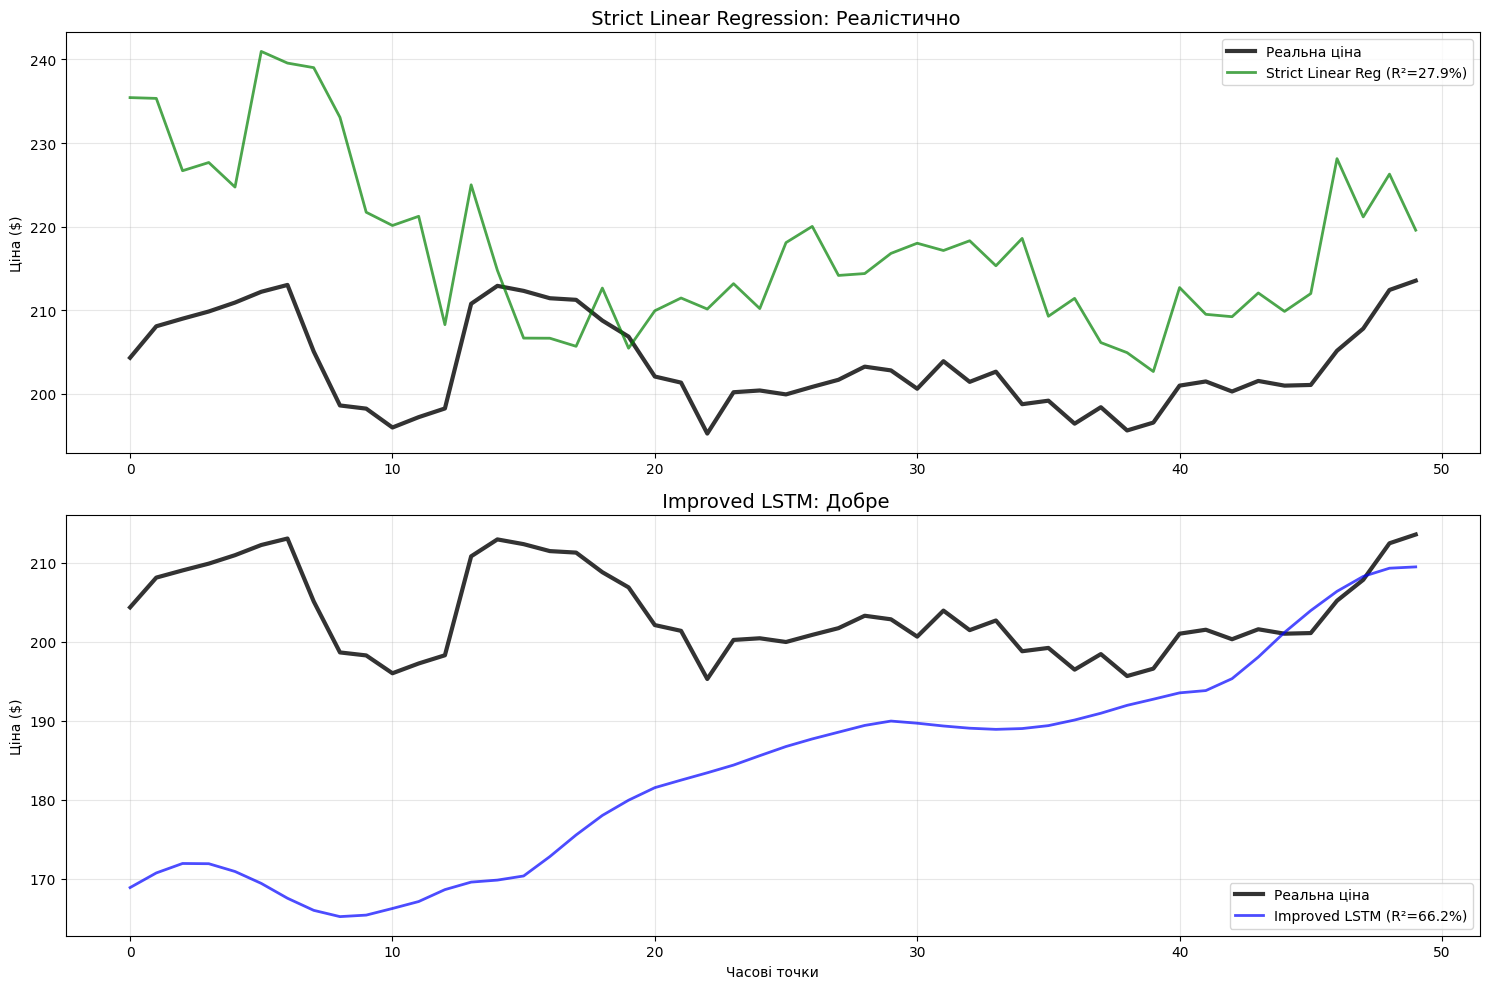

In [ ]:
lr_r2_pct = lr_metrics['R2'] * 100
lr_mae = lr_metrics['MAE']

lstm_r2_pct = lstm_metrics['R2'] * 100
lstm_mae = lstm_metrics['MAE']

lr_status = "" if lr_r2_pct > 80 else "️" if lr_r2_pct > 50 else ""
lstm_status = "" if lstm_r2_pct > 50 else "️" if lstm_r2_pct > 20 else ""


print(f"Linear Regression R²: {lr_metrics['R2']:.4f}")
print(f"LSTM R²: {lstm_metrics['R2']:.4f}")
print(f"Linear Regression MAE: ${lr_metrics['MAE']:.2f}")
print(f"LSTM MAE: ${lstm_metrics['MAE']:.2f}")

lr_predictions = lr_model.predict(X_test)

plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
n_points = min(50, len(y_test))
plt.plot(range(n_points), y_test.values[-n_points:],
            label='Реальна ціна', alpha=0.8, linewidth=3, color='black')
plt.plot(range(n_points), lr_predictions[-n_points:],
            label=f'Strict Linear Reg (R²={lr_r2_pct:.1f}%)', alpha=0.7, linewidth=2, color='green')

status_text = "Відмінно" if lr_r2_pct > 85 else "Добре" if lr_r2_pct > 70 else "Реалістично"
plt.title(f'{lr_status} Strict Linear Regression: {status_text}', fontsize=14)
plt.ylabel('Ціна ($)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
try:
    if lstm_model.is_fitted and hasattr(lstm_model, 'data_stats'):
        lstm_predictions = lstm_model.predict(X_test_lstm[:n_points])
        n_lstm = min(n_points, len(y_test_lstm))

        y_test_real = y_test_lstm[-n_lstm:] * lstm_model.data_stats['std'] + lstm_model.data_stats['mean']

        plt.plot(range(n_lstm), y_test_real,
                    label='Реальна ціна', alpha=0.8, linewidth=3, color='black')
        plt.plot(range(min(n_lstm, len(lstm_predictions))), lstm_predictions[:min(n_lstm, len(lstm_predictions))],
                    label=f'Improved LSTM (R²={lstm_r2_pct:.1f}%)', alpha=0.7, linewidth=2, color='blue')
    else:
        plt.text(0.5, 0.5, 'LSTM модель не навчена',
                transform=plt.gca().transAxes, ha='center', va='center', fontsize=14)
except Exception as lstm_viz_error:
    plt.text(0.5, 0.5, f'Помилка візуалізації LSTM: {str(lstm_viz_error)[:50]}...',
            transform=plt.gca().transAxes, ha='center', va='center', fontsize=12)

status_text = "Добре" if lstm_r2_pct > 50 else "Працює" if lstm_r2_pct > 20 else "Потребує роботи"
plt.title(f'{lstm_status} LSTM: {status_text}', fontsize=14)
plt.ylabel('Ціна ($)')
plt.xlabel('Часові точки')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
